In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [141]:
ot = pd.read_csv("mwc22-orders_table.csv")
ot.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [142]:
# We must replace commas with dots to avoid getting errors.
ct = pd.read_csv("mwc22-client_table.csv",decimal=',')
ct.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,67.25,201.75,0
1,24321859,2,58.33,350.00,0
2,24321880,3,46.67,112.00,0
3,24321957,2,50.00,600.00,0
4,24321962,4,10.00,120.00,0


##### Exploratory Data Analysis and Data Preprocessing

In [143]:
# Check the missing data or nulls
def missing_data(x):
    total = x.isnull().sum().sort_values(ascending=False)
    percent = (x.isnull().sum()/x.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
    return missing_data

In [144]:
# Correlation heatmap
def correlation(x):
    corrmat = x.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=.8, square=True, annot=True)

In [145]:
missing_data(ot)

,Total,Percent
CLIENT ID,0,0.00
NB PRODS,0,0.00
ORDER ID,0,0.00
FRUIT_PRODUCT,0,0.00


In [146]:
missing_data(ct)

,Total,Percent
CLIENT ID,0,0.00
CLIENT_SEGMENT,0,0.00
AVG CONSO,0,0.00
AVG BASKET SIZE,0,0.00
RECEIVED_COMMUNICATION,0,0.00


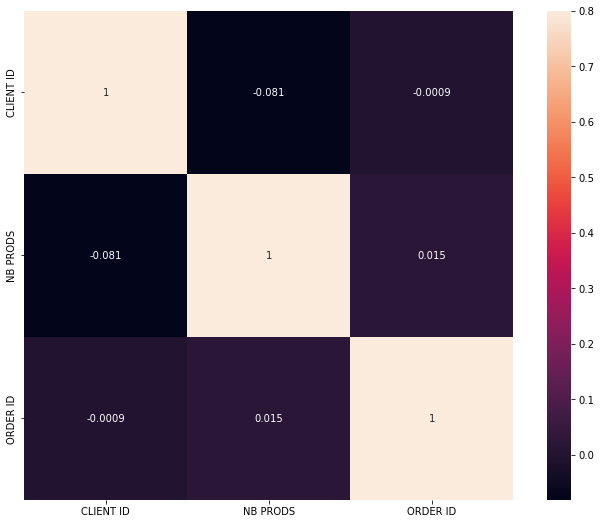

In [147]:
# Check the correlation in both Data Frames
correlation(ot)

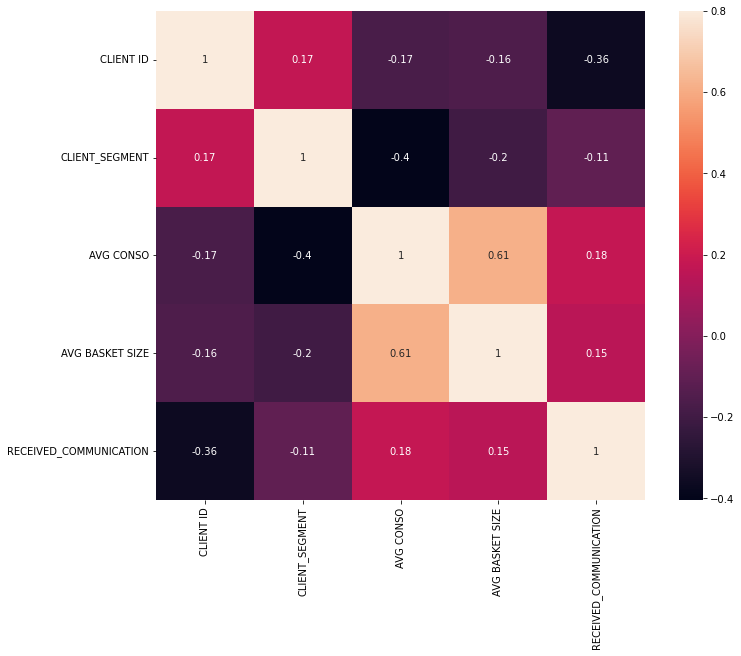

In [148]:
correlation(ct)

Apparently, there is a little correlation between average consumption and the client segment. Thus, we can hypothesise that the consumntion it is indeed related to the segment. What has to do with the promotion, it has low effect on AVG CONSO or AVG BASKET SIZE, only being related to the CLIENT ID.

In [149]:
ct.pivot_table(index=["CLIENT_SEGMENT"], aggfunc="size")

CLIENT_SEGMENT
1    6505
2    6760
3    8123
4    7927
5    3429
6    3140
dtype: int64

In [150]:
# Average fruit purchase per order
pd.options.display.float_format = "{:,.2f}".format
pd.DataFrame(ot.groupby("FRUIT_PRODUCT")["NB PRODS"].mean().sort_values(ascending=False))

,NB PRODS
FRUIT_PRODUCT,
Cheery,6.58
Pear,6.19
Lemon,6.01
Kiwi,5.60
Orange,5.53
Nuwe Fruit,5.38
Nectarine,5.38
Banana,5.18
Coconut,4.88


Now we know that the most purchased fruits are the cheerries.

In [151]:
pd.DataFrame(ct["AVG CONSO"].describe())

,AVG CONSO
count,"35,884.00"
mean,64.53
std,64.38
min,0.83
25%,20.83
50%,50.00
75%,88.17
max,"2,433.33"


Just by looking at the mean and the standard deviation we can deduce that there's something wrong here. And the proof of it lies in the enormous difference between the max and the 75% quantile. So, it seems we have a huge amount of outlieres that deviate the mean due to its sensitivity to extreme values. And since we are intersted in knowing how most of the clients behave, it would be a good idea to remove those outliers from our data.

In [152]:
pd.DataFrame(ct["AVG BASKET SIZE"].describe())

,AVG BASKET SIZE
count,"35,884.00"
mean,181.22
std,129.60
min,10.00
25%,100.00
50%,160.00
75%,225.00
max,"3,400.20"


Again, we can see the same pattern above the 3rd quartile, with a deviation between the median and the mean that points out the impact of these outliers. 

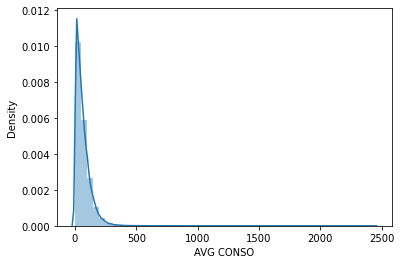

In [153]:
sns.distplot(ct["AVG CONSO"]);

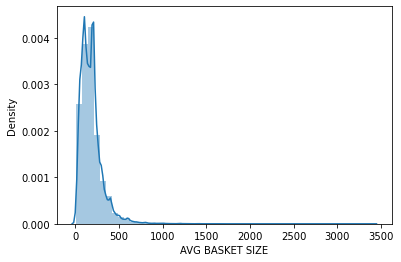

In [154]:
sns.distplot(ct["AVG BASKET SIZE"]);

Here we can graphically appreciate how skewed our data really is. 

In [155]:
def moments(x, y):
    print(f"Skewness of {y}: %f" % x[y].skew())
    print(f"Kurtosis of {y}: %f" % x[y].kurt())
    print()

In [156]:
moments(ct, "AVG BASKET SIZE")
moments(ct, "AVG CONSO")

Skewness of AVG BASKET SIZE: 3.061331
Kurtosis of AVG BASKET SIZE: 27.357909

Skewness of AVG CONSO: 5.067530
Kurtosis of AVG CONSO: 94.212367



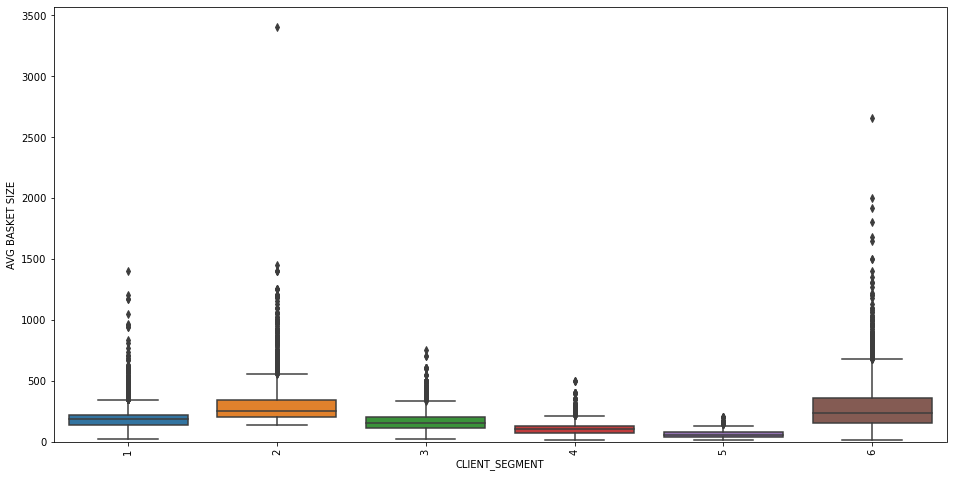

In [157]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=ct["CLIENT_SEGMENT"], y=ct["AVG BASKET SIZE"])
fig.axis(ymin=0);
plt.xticks(rotation=90);

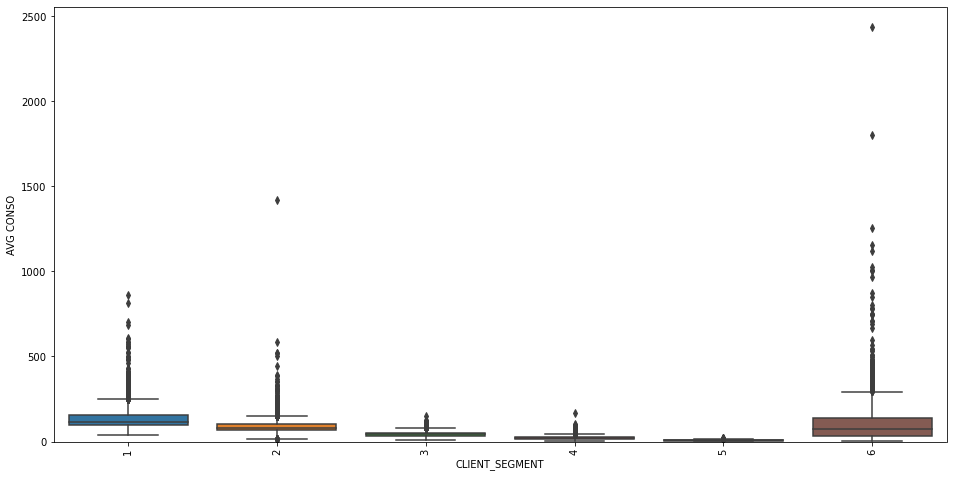

In [158]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=ct["CLIENT_SEGMENT"], y=ct["AVG CONSO"])
fig.axis(ymin=0);
plt.xticks(rotation=90);

In both cases, the boxplots are nearly invisible due to the presence of these extreme values. But just to be sure, let's perform a probability plot for some normality check.

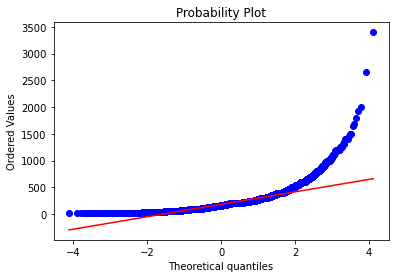

In [159]:
res = stats.probplot(ct["AVG BASKET SIZE"], plot=plt)

There is definetly some non-normal behaviour in the tails. Let's try to see if both variables might have a more "normal-shape" with a log-transformation before we cut the tails. 

<AxesSubplot:>

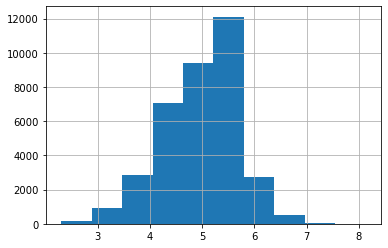

In [160]:
ct["AVG BASKET SIZE"].apply(np.log).hist()

<AxesSubplot:>

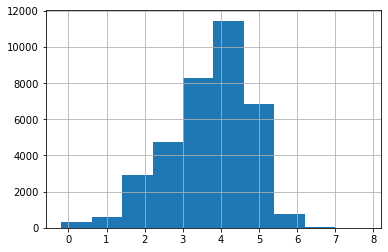

In [161]:
ct["AVG CONSO"].apply(np.log).hist()

##### Removing outliers

In [162]:
# Position of the Outliers
print(np.where(ct["AVG CONSO"]>250))

(array([   72,   154,   301,   450,   618,   752,   863,  1035,  1070,
        1133,  1139,  1186,  1318,  1495,  1551,  1609,  1867,  1900,
        2032,  2197,  2313,  2324,  2405,  2746,  2771,  2796,  2855,
        2882,  2885,  2896,  2981,  3028,  3040,  3132,  3263,  3423,
        3476,  3484,  3487,  3572,  3676,  3757,  3795,  3856,  3967,
        4025,  4072,  4151,  4346,  4560,  4596,  4695,  4826,  4857,
        4962,  4980,  5471,  5613,  5703,  5737,  5791,  5948,  6040,
        6049,  6052,  6138,  6213,  6223,  6257,  6268,  6320,  6394,
        6459,  6466,  6575,  6639,  6660,  6712,  6715,  7032,  7212,
        7231,  7234,  7253,  7420,  7588,  7998,  8003,  8168,  8194,
        8368,  8369,  8495,  8619,  8917,  9014,  9136,  9167,  9200,
        9258,  9502,  9529,  9736,  9876,  9909,  9968,  9985, 10049,
       10102, 10174, 10369, 10399, 10464, 10510, 10588, 10891, 10955,
       10990, 10996, 11069, 11072, 11081, 11087, 11111, 11447, 11458,
       11590, 11675

We now remove the tails via the interquartile range cut.

In [163]:
Q1 = ct.quantile(0.25)
Q3 = ct.quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
print(low, upper)

CLIENT ID                1,854,710.75
CLIENT_SEGMENT                  -1.00
AVG CONSO                      -80.18
AVG BASKET SIZE                -87.50
RECEIVED_COMMUNICATION          -1.50
dtype: float64 CLIENT ID                51,663,786.75
CLIENT_SEGMENT                    7.00
AVG CONSO                       189.18
AVG BASKET SIZE                 412.50
RECEIVED_COMMUNICATION            2.50
dtype: float64


In [164]:
trimmed_ct = ct[~((ct < low) | (ct > upper)).any(axis=1)]
trimmed_ct.shape   

(33363, 5)

Now that we've handled the outliers, we might continue with our EDA and notice how the boxplots have changed.

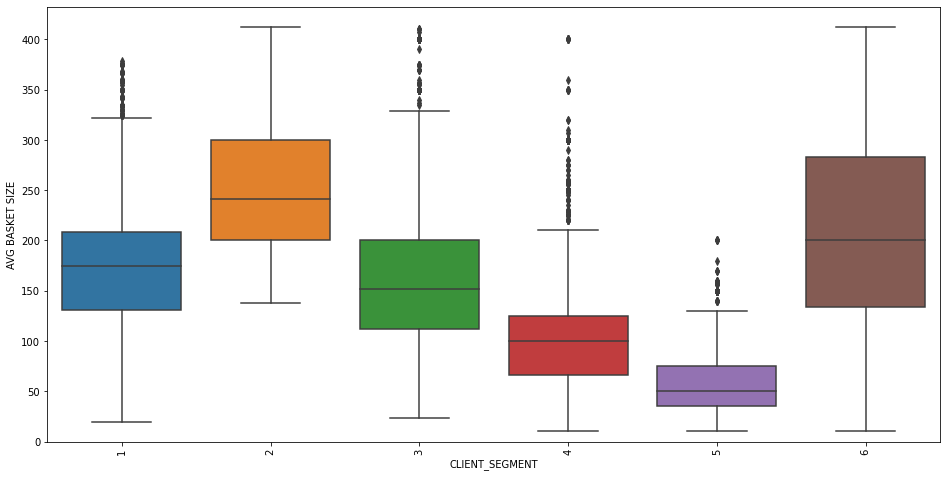

In [165]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=trimmed_ct["CLIENT_SEGMENT"], y=trimmed_ct["AVG BASKET SIZE"])
fig.axis(ymin=0);
plt.xticks(rotation=90);

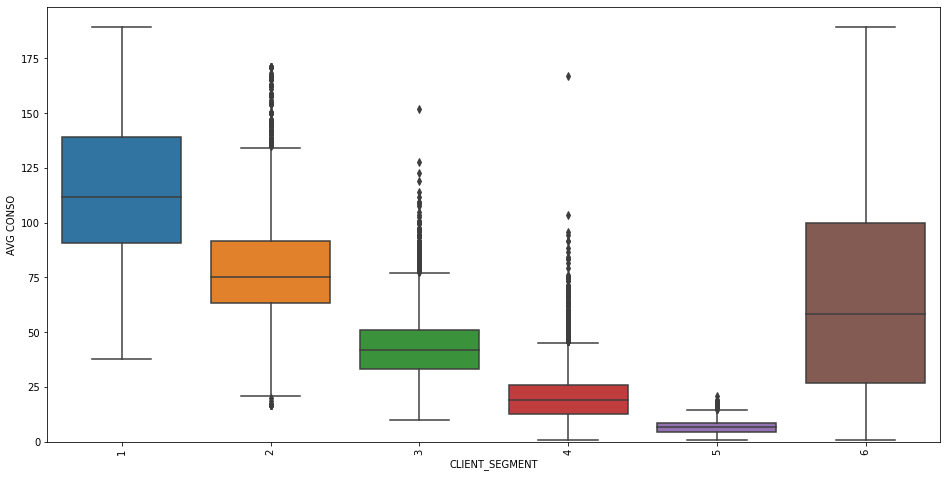

In [166]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=trimmed_ct["CLIENT_SEGMENT"], y=trimmed_ct["AVG CONSO"])
fig.axis(ymin=0);
plt.xticks(rotation=90);

We might see a pattern, except for segment 6, the closer to the 1st segment, the more distributed its data, and the higher is the average consumption.

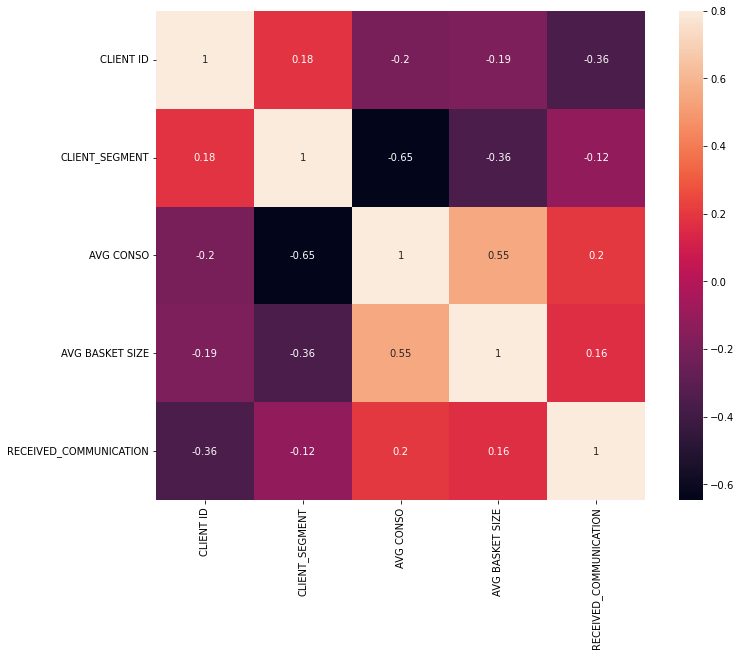

In [167]:
correlation(copy)

Now that we've removed the noise, we can see that indeed, there is a much more significant correlation between AVG CONSO and CLIENT_SEGMENT. Yet, the RECEIVED_COMMUNICATION variable, doesn't seem to play any significant role at all.

<AxesSubplot:xlabel='CLIENT_SEGMENT', ylabel='count'>

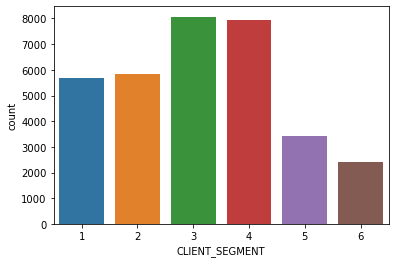

In [168]:
# Check the target variable
sns.countplot(copy["CLIENT_SEGMENT"])

<AxesSubplot:xlabel='RECEIVED_COMMUNICATION', ylabel='count'>

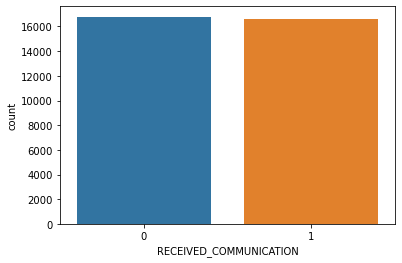

In [169]:
sns.countplot(copy["RECEIVED_COMMUNICATION"])

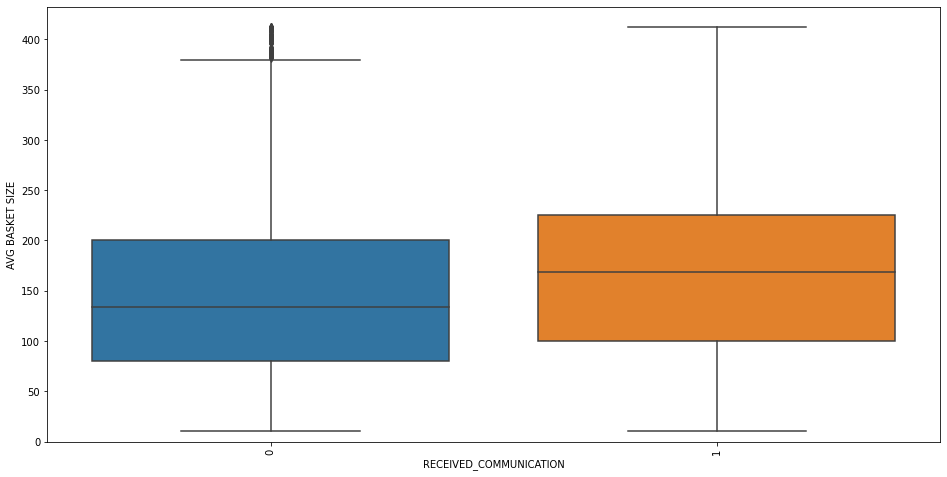

In [170]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=trimmed_ct["RECEIVED_COMMUNICATION"], y=trimmed_ct["AVG BASKET SIZE"])
fig.axis(ymin=0);
plt.xticks(rotation=90);

There is not significant difference in the basket size between those who received and those who didn't receive any information. 

##### CatBoost and Prediction

In [171]:
y = trimmed_ct["CLIENT_SEGMENT"]
x = trimmed_ct.drop("CLIENT_SEGMENT", 1)

In [172]:
x_test = pd.read_csv("mwc22-client_table+-+test_x.csv", decimal=',')
x_test.head()

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078,8.33,100.00,0
1,18072186,93.42,186.83,1
2,48352246,45.83,137.50,0
3,18070621,16.67,200.00,1
4,48352262,13.33,160.00,0


In [173]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices="0:1",
                           learning_rate=0.01,
                           depth=2,
                           loss_function="MultiClass")

model.fit(x, y, verbose=False)

y_pred = model.predict(x_test)
print(y_pred)

[[5]
 [1]
 [3]
 [4]
 [4]
 [4]
 [4]
 [3]
 [4]
 [2]
 [1]
 [1]
 [2]
 [5]
 [1]
 [3]
 [4]
 [1]
 [1]]


In [174]:
final_results = x_test["CLIENT ID"]

In [175]:
final_results = pd.concat([pd.DataFrame(final_results), pd.DataFrame(y_pred)], axis=1)

In [176]:
final_results = final_results.set_axis(["CLIENT ID", "CLIENT_SEGMENT"], axis=1)

In [177]:
final_results.to_csv("results.csv", index = False)